# Results and plots
This notebook loads the results of an experiment and provides the code that is used for plotting. It also implements functions to compute our test metrics (ROC and FPR) from the raw results (using bootstrapping for statistical significance). 

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
def get_roc_fp(results, nfolds=10):
    roc = []
    fp = []
    for i in range(nfolds):
        roc.append(results[i]["roc"])
        fp.append(results[i]["fp"])
    return roc, fp

def load_results(experiment_path):
    with open(os.path.join(experiment_path, "results\\nonnested_cval_mltsatt_l819.pkl"), 'rb') as f:
        results = pickle.load(f)
    return results

def concatenate_test_fold(results, nfolds=10):
    index = []
    y_real = []
    y_pred = []
    oversampler_col = []
    language = []
    for i in range(nfolds):
        index.extend(results[i]["test_index"])
        y_real.extend(results[i]["y_resampled_val"])
        y_pred.extend(results[i]["y_pred"])

        # Order the demographics data according to the test index
        for idx in results[i]["test_index"]:
            oversampler_col.append(results["demographics"]["oversampler_col"][idx])
            language.append(results["demographics"]["language"][idx])

    return dict(index=index, y_real=y_real, y_pred=y_pred, oversampler_col=oversampler_col, language=language)

def calculate_FPR(y_real, y_pred):
    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_real, y_pred).ravel()
    
    # Calculate the FP rate
    fp_rate = fp / (fp + tn)
    
    return fp_rate

def bootstrap_fpr(y_true, y_pred, only_fpr = False, only_mean = False ,n_bootstrap=1000, confidence_level=0.95):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    fpr_list = []

    for _ in range(n_bootstrap):
        # Create a bootstrap sample
        sample_indices = np.random.randint(0, len(y_true), len(y_true))
        y_true_sample = y_true[sample_indices]
        y_pred_sample = y_pred[sample_indices]

        # Calculate confusion matrix elements
        tn, fp, *_ = confusion_matrix(y_true_sample, y_pred_sample).ravel()

        # Calculate FPR and append to list
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fpr_list.append(fpr)

    if only_fpr:
        return fpr_list
    elif only_mean:
        return np.mean(fpr_list)
    else:
        # Calculate mean FPR and 95% confidence interval
        fpr_mean = np.mean(fpr_list)
        fpr_std = np.std(fpr_list)
        lower_bound = np.percentile(fpr_list, (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(fpr_list, (1 + confidence_level) / 2 * 100)
        
        return fpr_mean, fpr_std, lower_bound, upper_bound

def calculate_fpr_tpr_by_demographic(y_real, y_pred, demographics, only_fpr = False, only_mean = False , two_languages = False):
    # Create dictionaries to hold FPR and TPR for each demographic group
    fpr_by_demographic = {}
    fpr_separate = []

    # Iterate through each unique demographic group
    for demographic in set(demographics):
        # Extract indices for the current demographic group
        indices = [i for i, x in enumerate(demographics) if x == demographic]

        # Subset the true and predicted labels for the current demographic group
        y_real_sub = [y_real[i] for i in indices]
        y_pred_sub = [y_pred[i] for i in indices]


        # Calculate FPR and add to the dictionary
        fpr = bootstrap_fpr(y_real_sub, y_pred_sub, only_fpr=only_fpr, only_mean=only_mean)
        if two_languages:
            fpr_separate.append(fpr)
        else:
            fpr_by_demographic[demographic] = fpr

        # # Calculate TPR (recall) and add to the dictionary
        # tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        # tpr_by_demographic[demographic] = tpr
            
    if two_languages:
        return fpr_separate[0], fpr_separate[1]
    else:
        return fpr_by_demographic

# Get metrics from the pickle file

In [3]:
# absolute path to experiment result folder
experiment_path = r"C:\Users\david\Documents\GitHub\ml2\experiments\baseline\break_sequence\equal_balancing_oversampling\label_language\2023_12_18_0"

with open(os.path.join(experiment_path, "results\\nonnested_cval_mltsatt_l819.pkl"), 'rb') as f:
    results = pickle.load(f)

with open(os.path.join(experiment_path,'config.yaml'), 'rb') as f:
    config_info = pickle.load(f)

In [4]:
config_info

{'experiment': {'root_name': 'baseline/break_sequence/equal_balancing_oversampling/label_language',
  'name': '/2023_12_18_0/',
  'type': 1,
  'labels': 'binconcepts'},
 'data': {'key': 'break_sequence',
  'others': ({'gender': ['3', '4']},),
  'adjuster': {'limit': 819}},
 'ml': {'nfolds': 10,
  'epochs': 30,
  'oversampler': {'oversampling_factor': 1.5,
   'oversampling_col': ['label', 'language'],
   'rebalancing_mode': 'equal_balancing',
   'addyourownparameters': 'helloworld',
   'mode': 'none'},
  'splitter': {'stratifier_col': ['stratifier_column']}},
 'seeds': {'splitter': 219, 'oversampler': 13, 'model': 139, 'numpy': 36},
 'mode': 'baseline'}

In [5]:
print("Size original_TRAIN data:", len(results[1]["train_index"]),"(withouth the",len(results[1]["test_index"]),"used for TEST data)", "\n")
# Good to see if type of oversampling work well as leat dimensionality 
print("Size Total data after os:",len(results[1]["oversample_indexes"]),"(unique index of oversampling check if <",len(np.unique(np.array(results[1]["oversample_indexes"]))),"> equal to original_TRAIN size)","\n")

Size original_TRAIN data: 228 (withouth the 26 used for TEST data) 

Size Total data after os: 228 (unique index of oversampling check if < 228 > equal to original_TRAIN size) 



In [6]:
test = concatenate_test_fold(results)
test.keys()

dict_keys(['index', 'y_real', 'y_pred', 'oversampler_col', 'language'])

In [7]:
roc, folds_fpr = get_roc_fp(results)
real_fpr = calculate_FPR(test["y_real"], test["y_pred"])
mean_fpr, std_fpr ,lower_ci, upper_ci = bootstrap_fpr(test["y_real"], test["y_pred"])

print(f"ROC: {np.mean(roc):.3f} +/- {np.std(roc):.3f}")
print(f"Mean FPR: {mean_fpr:.3f} +/- {std_fpr:.3f}, 95% CI: [{lower_ci}, {upper_ci}]")

ROC: 0.647 +/- 0.107
Mean FPR: 0.286 +/- 0.037, 95% CI: [0.21984115418245412, 0.3586340456532297]


In [8]:
print("FPR mean accros folds: ",f"FP: {np.mean(folds_fpr):.3f} +/- {np.std(folds_fpr):.3f}")
print("FPR of test conconated: ",f"FP: {np.mean(real_fpr):.3f} +/- {np.std(real_fpr):.3f}")
print(f"Mean FPR with bootstrapping: {mean_fpr:.3f} +/- {std_fpr:.3f}, 95% CI: [{lower_ci}, {upper_ci}]")

FPR mean accros folds:  FP: 0.286 +/- 0.111
FPR of test conconated:  FP: 0.287 +/- 0.000
Mean FPR with bootstrapping: 0.286 +/- 0.037, 95% CI: [0.21984115418245412, 0.3586340456532297]


In [9]:
lang_fpr_results= calculate_fpr_tpr_by_demographic(test["y_real"], test["y_pred"], test["language"], only_mean=True)

lang_results_df = pd.DataFrame({
'Demographic': lang_fpr_results.keys(),
    'FPR': lang_fpr_results.values()})
lang_results_df

,Demographic,FPR
0,Deutsch,0.248903
1,Français,0.360069


In [10]:
# Logic label 1 can't have a FPR, as it's the label we want to predict
ov_fpr_results = calculate_fpr_tpr_by_demographic(
    test["y_real"], test["y_pred"], test["oversampler_col"], only_mean=True)

ov_results_df = pd.DataFrame({
    'Demographic': ov_fpr_results.keys(),
    'FPR': ov_fpr_results.values(),})
ov_results_df

,Demographic,FPR
0,1Deutsch,0.000000
1,0Deutsch,0.251667
2,0Français,0.365043
3,1Français,0.000000


# Figures

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

## Fig.1 Oversampling distribution

In [12]:
# Correspond to 100 % of the original data
print(len(results["demographics"]["oversampler_col"]))

# count the number of unique values in the demographics
print(np.unique(results["demographics"]["oversampler_col"], return_counts=True))
print(np.unique(results["demographics"]["label"], return_counts=True))

254
(array(['0Deutsch', '0Français', '1Deutsch', '1Français'], dtype='<U9'), array([96, 47, 82, 29], dtype=int64))
(array(['0', '1'], dtype='<U1'), array([143, 111], dtype=int64))


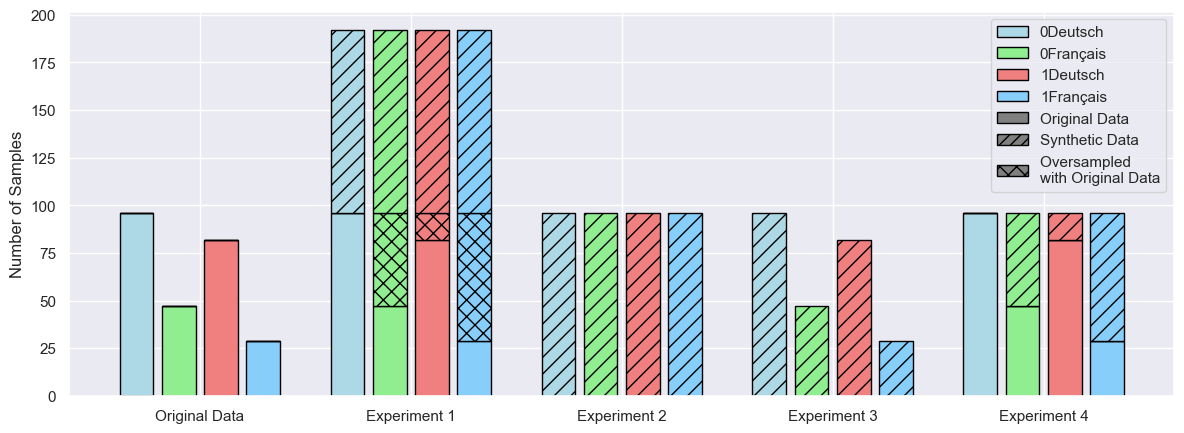

In [13]:
labels = ['0Deutsch', '0Français', '1Deutsch', '1Français']
names = ['Original Data', 'Experiment 1', 'Experiment 2', 'Experiment 3', 'Experiment 4']
group_colors = {'0Deutsch': 'lightblue', '0Français': 'lightgreen', '1Deutsch': 'lightcoral', '1Français': 'lightskyblue'}

experiments = [
    [('0Deutsch', 96), ('0Français', 47), ('1Deutsch', 82), ('1Français', 29)],
    [('0Deutsch', 192), ('0Français', 192), ('1Deutsch', 192), ('1Français', 192)],
    [('0Deutsch', 96), ('0Français', 96), ('1Deutsch', 96), ('1Français', 96)],
    [('0Deutsch', 96), ('0Français', 47), ('1Deutsch', 82), ('1Français', 29)],
    [('0Deutsch', 96), ('0Français', 96), ('1Deutsch', 96), ('1Français', 96)]]
experiments_dict = {f'{names[i]}': dict(experiment) for i, experiment in enumerate(experiments)}

original_counts_dict = dict(experiments[0])
original_max_count = max(dict(experiments[0]).values())
types = [0, 1, 2, 2, 0]

def get_counts(label, type):
    oversampling_count = 0
    if type == 0:
        original_count = original_counts_dict.get(label, 0)
        synthetic_count = counts.get(label, 0) - original_count
    if type == 1:
        original_count = original_counts_dict.get(label, 0)
        oversampling_count = original_max_count - original_count
        synthetic_count = counts.get(label, 0) - original_count - oversampling_count
    if type == 2:
        original_count = 0
        synthetic_count = counts.get(label, 0)
    return original_count , synthetic_count, oversampling_count


plt.figure(figsize=(12, 4.5))
for i, (name, counts) in enumerate(experiments_dict.items()):
    for j, label in enumerate(labels):
        # Position for each bar in the combined chart
        pos = j + i * (len(labels) + 1)  # Adding a space between experiments

        original_count, synthetic_count, oversampling_count = get_counts(label, types[i])

        # Plotting bars for original and synthetic data
        plt.bar(pos, original_count, color=group_colors[label], edgecolor='black')
        plt.bar(pos, oversampling_count, bottom=original_count , color=group_colors[label], hatch='xx', edgecolor='black')
        plt.bar(pos, synthetic_count, bottom=original_count + oversampling_count, color=group_colors[label], hatch='//', edgecolor='black')
        

# Adding x-ticks, labels, and title
plt.xticks([i * (len(labels) + 1) + 1.5 for i in range(len(experiments_dict))], experiments_dict.keys())
plt.ylabel('Number of Samples')
# plt.title('Original distribution of the data and the four oversampling strategies')

for label, color in group_colors.items():
    plt.bar(0, 0, color=color, label=label, edgecolor='black')  # Dummy bars for legend
plt.bar(0, 0, color='gray', label='Original Data', edgecolor='black')  # Dummy bar for original data
plt.bar(0, 0, color='gray', hatch='///', label='Synthetic Data', edgecolor='black')  # Dummy bar for synthetic data
plt.bar(0, 0, color='gray', hatch='xx', label='Oversampled \nwith Original Data', edgecolor='black') 
plt.legend()


plt.tight_layout()
plt.savefig('Oversampling_distribution.png', dpi=800)
plt.show()

## Fig.2 Baseline

In [14]:
def plot_box_plots(metrics, metrics_to_plot, y_labels, colors, file_name=None):
    # Create a figure with a subplot for each metric
    fig, axs = plt.subplots(len(metrics_to_plot), figsize=(8, 6), sharex=True)

    # fig.suptitle(title)

    # Creating box plots for the given metrics
    for i, (ax, (metric, color, y_label)) in enumerate(zip(axs, zip(metrics_to_plot, colors, y_labels))):
        values = [exp_metrics[metric] for exp_metrics in metrics.values()]
        ax.boxplot(values, patch_artist=True, boxprops=dict(facecolor=color))
        ax.set_ylabel(y_label)
        if i != len(metrics_to_plot) -1 :  # if it's not the last subplot
            ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # remove x-tick labels

    # Set the x-axis labels once, after creating all the box plots
    axs[-1].set_xticks(np.arange(len(metrics)) + 1)
    axs[-1].set_xticklabels(metrics.keys())

    # Create a legend
    patches = [mpatches.Patch(color=color, label=metric.upper()) for metric, color in zip(metrics_to_plot, colors)]
    # fig.legend(handles=patches, loc='upper right')

    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name, dpi=800)
    plt.show()

In [15]:
experiments = {
    "baseline": r"C:\Users\david\Documents\ml_project2\experiments\baseline\break_sequence\equal_balancing_oversampling\label_language\2023_12_18_0",
    "ROS": r"C:\Users\david\Documents\ml_project2\experiments\label_label\equal_balancing_oversampling\label\2023_12_20_0",
    "experiment 1": r"C:\Users\david\Documents\ml_project2\experiments\exp1L1515\equal_balancing_oversampling\label\2023_12_20_0",
    "experiment 2": r"C:\Users\david\Documents\ml_project2\experiments\exp2L1515\equal_balancing_oversampling\label\2023_12_20_0",
    "experiment 3": r"C:\Users\david\Documents\ml_project2\experiments\exp3L1515\equal_balancing_oversampling\label\2023_12_20_0",
    "experiment 4": r"C:\Users\david\Documents\ml_project2\experiments\exp4L1515\equal_balancing_oversampling\label\2023_12_20_0"
}

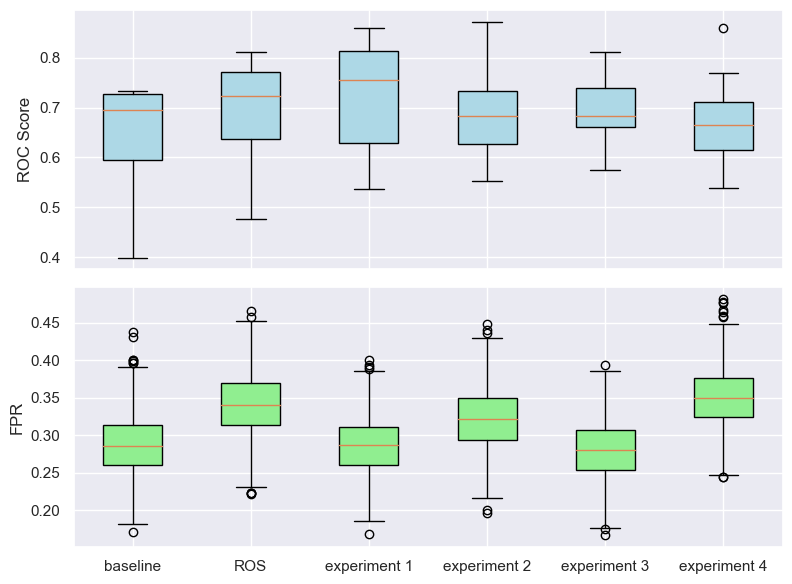

In [45]:
# New version with bootstrap for calculating FPR

metrics = {}
for name, path in experiments.items():
    results = load_results(path)
    test = concatenate_test_fold(results)
    metrics[name] = {} # Initialize an empty dictionary
    metrics[name]["roc"], _  = get_roc_fp(results)
    metrics[name]["fpr"] = bootstrap_fpr(test["y_real"], test["y_pred"], only_fpr=True)

plot_box_plots(metrics, ["roc", "fpr"], ['ROC Score', 'FPR'], ["lightblue", "lightgreen"], file_name='ROC scores and FPR Across Experiments.png')

In [46]:
for name, path in metrics.items():
    print(np.mean(np.array(metrics[name]["fpr"])))

0.2874809775527608
0.34195273955018207
0.2855545071548085
0.32209235191808716
0.27985565922925276
0.34970677664514915


In [47]:
# Old version without bootstrap for calculating FPR

metrics = {}
for name, path in experiments.items():
    results = load_results(path)
    metrics[name] = {} # Initialize an empty dictionary
    metrics[name]["roc"], metrics[name]["fp"] = get_roc_fp(results)

# plot_box_plots(metrics, ["roc", "fp"], 'ROC scores and FPR Across Experiments', ['ROC Score', 'FPR'], ["lightblue", "lightgreen"])

## Fig.3 Demographics bias

In [16]:
def plot_grouped_bar_plots(metrics, metrics_to_plot, y_label, colors, file_name=None):
    n_experiments = len(metrics)

    fig, ax = plt.subplots(figsize=(8, 4))
    # fig.suptitle(title)

    bar_width = 0.35
    # Positions of the left bar-boundaries
    bar_l = [i + 1 for i in range(n_experiments)]
    # Positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i + (bar_width / 2) for i in bar_l]

    # Creating bar plots for the given metrics
    for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
        # Calculate the mean and standard deviation for each experiment
        values = [np.mean(exp_metrics[metric]) for exp_metrics in metrics.values()]
        std_dev = [np.std(exp_metrics[metric]) for exp_metrics in metrics.values()]

        ax.bar([l + (i * bar_width) for l in bar_l], values, width=bar_width,capsize=5, color=color, align='center', yerr=std_dev, label=metric)

    # Set the y-axis label
    ax.set_ylabel(y_label)

    # Set the x-axis labels
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(metrics.keys())

    # Adding the legend and showing the plot
    ax.legend(loc='upper left')
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name, dpi=800)
    plt.show()

In [19]:
experiments = {
    "baseline": r"C:\Users\david\Documents\GitHub\ml2\experiments\baseline\break_sequence\equal_balancing_oversampling\label_language\2023_12_18_0",
    "ROS": r"C:\Users\david\Documents\GitHub\ml2\experiments\label_label\equal_balancing_oversampling\label\2023_12_20_0",
    "experiment 1": r"C:\Users\david\Documents\GitHub\ml2\experiments\exp1L1515\equal_balancing_oversampling\label\2023_12_20_0",
    "experiment 2": r"C:\Users\david\Documents\GitHub\ml2\experiments\exp2L1515\equal_balancing_oversampling\label\2023_12_20_0",
    "experiment 3": r"C:\Users\david\Documents\GitHub\ml2\experiments\exp3L1515\equal_balancing_oversampling\label\2023_12_20_0",
    "experiment 4": r"C:\Users\david\Documents\GitHub\ml2\experiments\exp4L1515\equal_balancing_oversampling\label\2023_12_20_0"
}

metrics_demo = {}
for name, path in experiments.items():
    results = load_results(path)
    test = concatenate_test_fold(results)
    metrics_demo[name] = {} # Initialize an empty dictionary
    metrics_demo[name]["Deutsch"], metrics_demo[name]["Francais"] = calculate_fpr_tpr_by_demographic(test["y_real"], test["y_pred"], test["language"], only_fpr=True, two_languages=True)

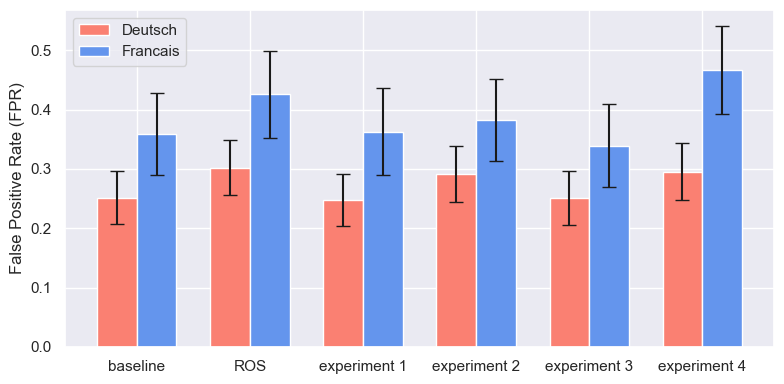

In [20]:
plot_grouped_bar_plots(metrics_demo, ["Deutsch", "Francais"], 'False Positive Rate (FPR)', ["salmon", "cornflowerblue"], file_name='FPR_language.png')

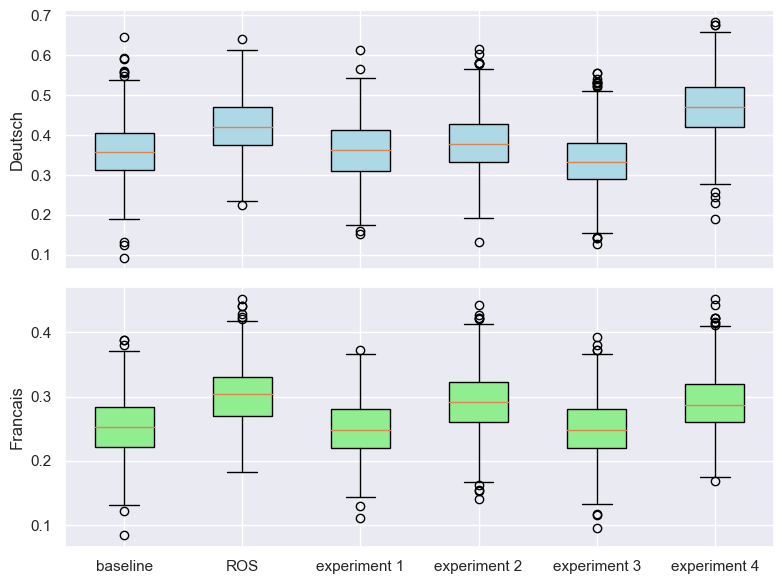

In [51]:
plot_box_plots(metrics_demo, ["Deutsch", "Francais"], ['Deutsch', 'Francais'], ["lightblue", "lightgreen"])